<a href="https://colab.research.google.com/github/Willyzw/monodepth2/blob/master/monodepth2_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Tracking the pose of a moving camera and simultanously inferring the **dense** 3D structure of the environment is a long-standing problem which is often denoted as **DenseSLAM**. Traditionally it is approached by two steps, namely a sparse set of feature points along with camera poses is firstly estimated, then followed by multi-view stereo(MVS) to construct the dense scene structure. While this traditional toolchain is well studied consisting of multiple elaborate hand-crafted stages, it lacks robustness in cases such as low texture, thin structure and dynamic objects. Besides that, modern applications like augmented reality or automated driving demand the ability of real-time dense scene perceiving for the operations like interaction between physical and virtual objects and obstacle avoidance.

With the advent of deep learning, there has been remarkable progress in this field in recent years. **MonoDepth2**[1] is one of the most representative works. It consists of a depth and a pose network to estimate depth map and camera motion respectively. More specifically, the pose network takes a pair of consecutive images $I_{t-1}$ and $I_t$ and outputs the relative motion $T^{t}_{t-1}$ from $I_{t-1}$ to $I_t$, while the depth network can map a RGB image $I_{t}$ though an encoder-decoder network to its corresponding depth map $D_t$. This process can be illustrated as the figure below (Figure 1 of SfMLearner [3])  
![](https://github.com/Willyzw/monodepth2/raw/master/assets/sfmlearner.png)

This notebook aims to convey the MonoDepth2's principle by showing examples. Firstly the required development environment will be set up. Then, the example images from KITTI dataset[4] are used to illustrate the process of image warping aka. `novel view synthesis`, which is the core principle for the self-supervised learning. At the end, we apply the pre-trained network model on short video clips of KITTI[4] and Cityscapes[5] dataset to check how does the trained model generalize to a different dataset.


# Environment setup

## Clone repository and install pytorch (Takes ~5mins)
Firstly, the commands below will clone the code repository and install needed python packages.

In [1]:
! git clone https://github.com/Willyzw/monodepth2
% cd /content/monodepth2/
#! pip install -q torch==1.7.0+cu110 torchvision==0.8.1+cu110 -f https://download.pytorch.org/whl/torch_stable.html

fatal: destination path 'monodepth2' already exists and is not an empty directory.
/content/monodepth2


## Import packages and models

In [2]:
%matplotlib inline
import os
import io
import cv2
import yaml
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output
from google.colab import files

import torch
from torchvision import transforms

import networks
from layers import *
from utils import *

Below we download the pre-trained network models, which was trained on KITTI dataset[4], so networks are initialied. The pre-trained models are made accessable by MonoDepth2's author. One can also train the model on an own dataset/video, which is not in the scope of this notebook. Please refer to the readme file of official repository https://github.com/nianticlabs/monodepth2.

In [3]:
! wget -nc https://storage.googleapis.com/niantic-lon-static/research/monodepth2/mono%2Bstereo_640x192.zip
! unzip -n mono+stereo_640x192.zip -d models
# Path to pre-trained models
depth_encoder_path = os.path.join("models", "encoder.pth")
depth_decoder_path = os.path.join("models", "depth.pth")
pose_encoder_path = os.path.join("models", "pose_encoder.pth")
pose_decoder_path = os.path.join("models", "pose.pth")

# Load depth net model
depth_encoder = networks.ResnetEncoder(18, False).cuda()
depth_decoder = networks.DepthDecoder(num_ch_enc=depth_encoder.num_ch_enc, scales=range(4)).cuda()

loaded_dict_enc = torch.load(depth_encoder_path)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in depth_encoder.state_dict()}
depth_encoder.load_state_dict(filtered_dict_enc)
depth_decoder.load_state_dict(torch.load(depth_decoder_path))

depth_encoder.eval()
depth_decoder.eval()

# Load pose net pre-trained model
pose_encoder = networks.ResnetEncoder(18, False, 2).cuda()
pose_encoder.load_state_dict(torch.load(pose_encoder_path))

pose_decoder = networks.PoseDecoder(pose_encoder.num_ch_enc, 1, 2).cuda()
pose_decoder.load_state_dict(torch.load(pose_decoder_path))

pose_encoder.eval()
pose_decoder.eval()

feed_width, feed_height = loaded_dict_enc['width'], loaded_dict_enc['height']

--2021-03-18 12:51:13--  https://storage.googleapis.com/niantic-lon-static/research/monodepth2/mono%2Bstereo_640x192.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.187.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103593905 (99M) [application/zip]
Saving to: ‘mono+stereo_640x192.zip’

mono+stereo_640x192 100%[===================>]  98.79M  16.9MB/s    in 5.8s    

2021-03-18 12:51:21 (16.9 MB/s) - ‘mono+stereo_640x192.zip’ saved [103593905/103593905]

Archive:  mono+stereo_640x192.zip
  inflating: models/depth.pth        
  inflating: models/encoder.pth      
  inflating: models/pose.pth         
  inflating: models/pose_encoder.pth  
  inflating: models/poses.npy        


# Self-supervised training
Training a network usually requires large amount of groundtruth data which is expensive to acquire at scale. Naturally it arises the question whether it is possible to train networks simply from ubiquitous unlabeled monocular videos. In other words, when trained supervisely the network can learn to predict the output as close as possible to the groundtruth data, while when groundtruth is unavailable where should such supervision signal come from? 

The key insight here is that when an image has its depth map estimated and knows a relative transform to a nearby view, the image can be warped into that nearby view to create a synthesized one. If the estimated depth map is not accurate, the synthesized image won't look realistic. Or if the relative transform doesn't correspond to the actual tranform to the wanted view, the synthesized image won't be the actual look from the certain camera pose. Thus by controlling the quality of syntheiszed image i.e. comparing the synthesized image with the actual image, the supervision signal is indirectly imposed into the network through the so-called gradient based neural network training.

## Load images
Here 4 images are loaded, among them the middle image namely `0000000069.png` are the target image, and the other 3 images are source images. They are the previous and next one of the target image in the video sequence and the corresponding right image taken by right camera respectively. Such 4 images are also denoted as `quadruplets` which is sampled from entire dataset during each training step.

In [4]:
def load_img(path):
  img = pil.open(path).convert('RGB')
  img_resized = img.resize((feed_width, feed_height), pil.LANCZOS)
  img_torch = transforms.ToTensor()(img_resized).unsqueeze(0).cuda()
  return img, img_resized, img_torch

img_target, img_target_resized, img_target_torch = load_img("assets/kitti/0000000069.png")
img_src_prev, img_src_prev_resized, img_src_prev_torch = load_img("assets/kitti/0000000068.png")
img_src_next, img_src_next_resized, img_src_next_torch = load_img("assets/kitti/0000000070.png")
img_src_right, img_src_right_resized, img_src_right_torch = load_img("assets/kitti/0000000069_r.png")

original_width, original_height = img_target.size

## Plot image with predicted depth
The code block below defines the functions to infer depth map for each input images and relative pose between a pair of images. In this example, the disparity map of 4 images are predicted, and the relative transform $T^{t}_{t-1}$ from previous image to target image, and $T^{t+1}_{t}$ from target to next image. 

In [5]:
def depth_inference(images):
    with torch.no_grad():
        depth_features = depth_encoder(torch.cat(images, 0))
        outputs = depth_decoder(depth_features)
        return outputs[("disp", 0)]

def pose_inference(images, invert=False):
    with torch.no_grad():
        pose_features = [pose_encoder(torch.cat(images, 1))]
        axisangle, translation = pose_decoder(pose_features)
        T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert)
        return T

disp_target, disp_src_prev, disp_src_next, disp_src_right = depth_inference([img_target_torch, img_src_prev_torch, img_src_next_torch, img_src_right_torch])
src_prev_T_target = pose_inference([img_src_prev_torch, img_target_torch], True)
src_next_T_target = pose_inference([img_target_torch, img_src_next_torch], False)


To demostrate the predicted result, original images are plotted overlayed with their corresponding disparity map. On the road surface, the smooth disparity transition can be observed. Remarkable is also the estimates on the pole at right side.

Text(0.5, 1.0, 'source image "right"')

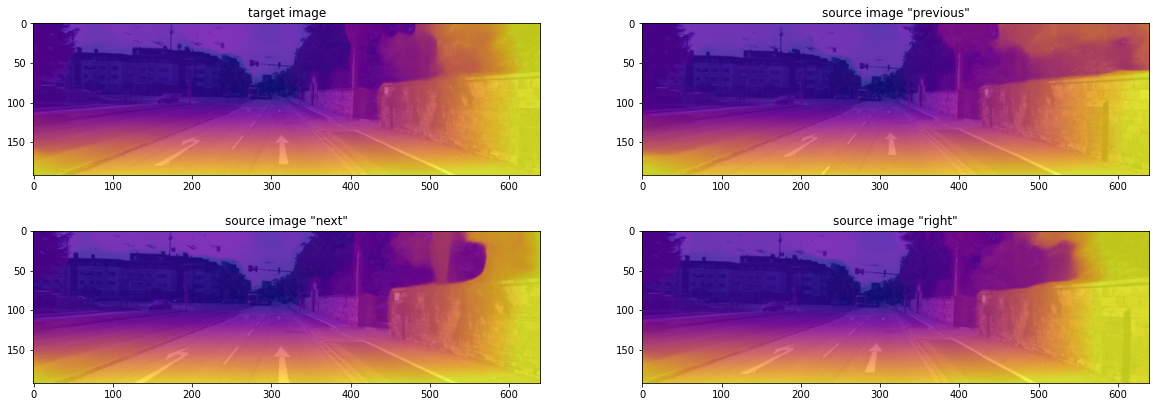

In [6]:
disp_target_np = disp_target.squeeze().cpu().numpy()
vmax = np.percentile(disp_target_np, 95)

alpha = 0.8
plt.figure(figsize=(20, 7))
plt.subplot(221)
plt.imshow(img_target_resized)
plt.imshow(disp_target_np, cmap='plasma', vmax=vmax, alpha=alpha)
plt.title('target image')
plt.subplot(222)
plt.imshow(img_src_prev_resized)
plt.imshow(disp_src_prev.squeeze().cpu().numpy(), cmap='plasma', vmax=vmax, alpha=alpha)
plt.title('source image "previous"')
plt.subplot(223)
plt.imshow(img_src_next_resized)
plt.imshow(disp_src_next.squeeze().cpu().numpy(), cmap='plasma', vmax=vmax, alpha=alpha)
plt.title('source image "next"')
plt.subplot(224)
plt.imshow(img_src_right_resized)
plt.imshow(disp_src_right.squeeze().cpu().numpy(), cmap='plasma', vmax=vmax, alpha=alpha)
plt.title('source image "right"')

## Load kamera intrinsics
Next is to demostrate how the source images can be warped to target view. One necessary pre-requisite for the warping process is the camera intrinsics, which it is loaded from the calibration file. Note technically the camera intrinsics can be learned as well, but not covered in MonoDepth2 paper (One can refer to  [6]).

In [7]:
with open('assets/kitti/calib_cam_to_cam.txt', 'r') as f:
    calib_cam = yaml.load(f)
K = np.fromstring(calib_cam['P_rect_02'], dtype=np.float32, sep=' ').reshape(3, 4)
K[:, -1] = 0
K = np.concatenate([K, np.array([0, 0, 0, 1]).reshape(1, 4)], axis=0)
print(K)

# rescale intrinsic matrix based on the ratio between original size and feed size
K[0] *= feed_width/original_width
K[1] *= feed_height/original_height
K_inv = np.linalg.inv(K)

[[721.53771973   0.         609.55932617   0.        ]
 [  0.         721.53771973 172.85400391   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]


## Warp source images to target frame
The objective of the self-supervised training is to minimize the photometric loss between the warped source image and target image. Here it will be shown how the source images are warped into the target view. In other words, how a new image of the scene seen from a different camera pose is synthesized. Given the camera intrinsic matrix $K$, relative camera motion $T_{target->source}$ as well as the depth map $D_t$ for target frame, the warping process $f$ can be represented by:

$$f_{target->source}(p_t) = \hat{p}_s = K T_{target->source} D_t(p_t) K^{-1} p_t$$

Hereby the projected camera coordinates $\hat{p}_s$ are non-integer numbers, so a differentiable version of bilinear sampling is applied to interpolate the values from four neighbors so that the entire process is still differentiable for the gradient-based neural network training. Running the process for all pixels a warped image $\hat{I}_s$ can be obtained. The training objective becomes to minimize the following loss function

$$\mathcal{L} =  \sum_{s} \sum_{p} |I_t(p) - \hat{I}_s(p)|$$

where $p$ indexes over all pixels, and $s$ being the source images in the sampled `quadruplets`. Note for brevity, we only list the straight-forward L1 loss function here for simplicity. However in reality this is not able to provide enough supervision signal, since the photoconsistency assumption is often violated by cases such as occlusion, dynamic objects or non-lambertian surfaces. Thus, in the MonoDepth2 paper, more sophisticated loss functions are proposed to convey stronger supervision signal during training so that the networks can be guided to predict more correct depth and camera pose.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


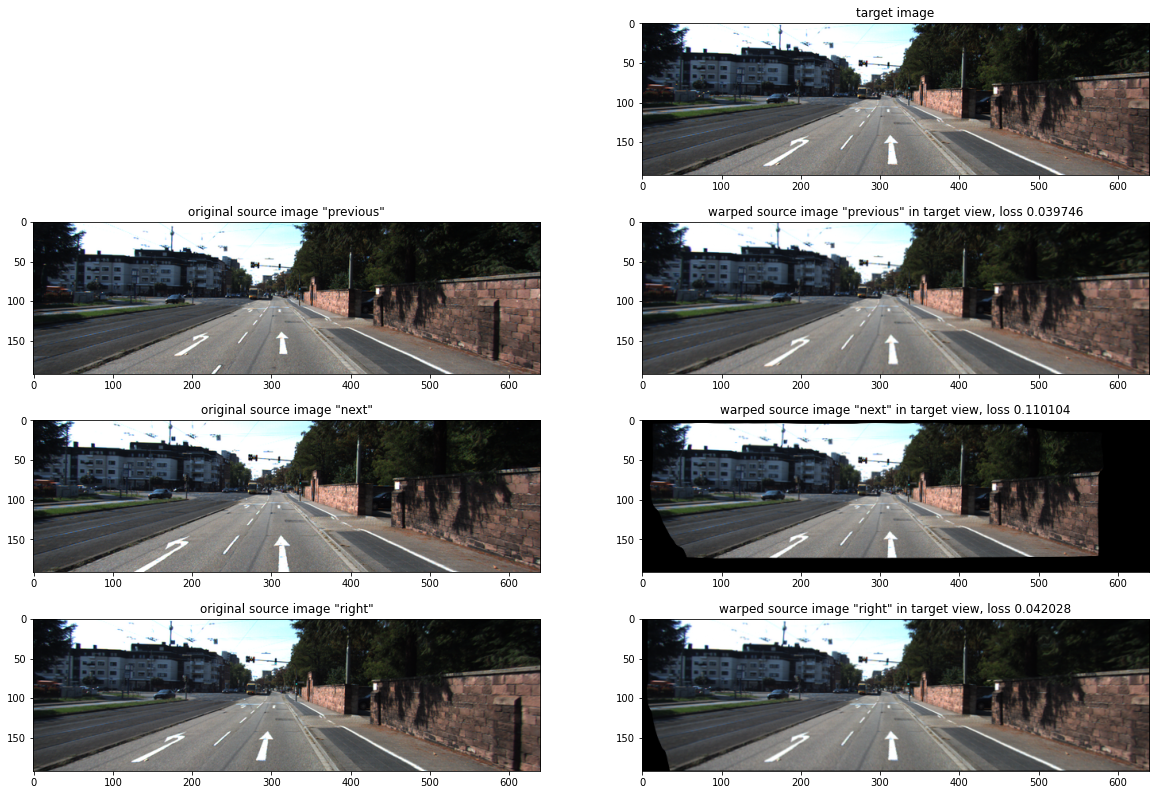

In [8]:
# convert disparity to depth
_, depth_target = disp_to_depth(disp_target, min_depth=0.1, max_depth=100)

backproject_depth = BackprojectDepth(1, feed_height, feed_width).cuda()
project_3d = Project3D(1, feed_height, feed_width).cuda()

# model was trained with a nomial baseline of 0.1 units
stereo_T = np.eye(4, dtype=np.float32)
stereo_T[0, 3] = -0.1

# back project the pixels of target image to 3D space
cam_points_target = backproject_depth(depth_target, torch.FloatTensor(K_inv[np.newaxis,:]).cuda())

# transform the 3d pixel coordinates from target frame to source frame and then project to 2d plane
pix_coords_src_prev = project_3d(cam_points_target, torch.FloatTensor(K[np.newaxis,:]).cuda(), src_prev_T_target)
pix_coords_src_next = project_3d(cam_points_target, torch.FloatTensor(K[np.newaxis,:]).cuda(), src_next_T_target)
pix_coords_src_right = project_3d(cam_points_target, torch.FloatTensor(K[np.newaxis,:]).cuda(), torch.from_numpy(stereo_T).cuda())

with torch.no_grad():
    img_src_prev_warped = F.grid_sample(img_src_prev_torch, pix_coords_src_prev, padding_mode="zeros")
    img_src_next_warped = F.grid_sample(img_src_next_torch, pix_coords_src_next, padding_mode="zeros")
    img_src_right_warped = F.grid_sample(img_src_right_torch, pix_coords_src_right, padding_mode="zeros")

plt.figure(figsize=(20, 14))
plt.subplot(422)
plt.title('target image')
plt.imshow(img_target_resized)
plt.subplot(424)
l1 = torch.abs(img_src_prev_warped-img_target_torch).mean()
plt.title('warped source image "previous" in target view, loss %f'%l1)
plt.imshow(img_src_prev_warped.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(423)
plt.title('original source image "previous"')
plt.imshow(img_src_prev_resized)
plt.subplot(426)
l1 = torch.abs(img_src_next_warped-img_target_torch).mean()
plt.title('warped source image "next" in target view, loss %f'%l1)
plt.imshow(img_src_next_warped.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(425)
plt.title('original source image "next"')
plt.imshow(img_src_next_resized)
plt.subplot(428)
l1 = torch.abs(img_src_right_warped-img_target_torch).mean()
plt.title('warped source image "right" in target view, loss %f'%l1)
plt.imshow(img_src_right_warped.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(427)
plt.title('original source image "right"')
plt.imshow(img_src_right_resized)

# Apply inference on video clips of KITTI and Cityscapes datasets

Below a function is defined for inferring the depth map for each frame of input video and the relative motion between every two consecutive frames. The color map "plasma" is applied to depth map visualization for better visual contrast. The resulted pose trajectory denoted as Visual Odometry(VO) result will be plotted in x-y plane. Finally, original image, colorized depth map and VO plot are combined as a new frame of the result video.

In [9]:
def show_and_stream_result_video(input_video, output_path):
    # video reader
    cap = cv2.VideoCapture(input_video)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # init pose as original point
    prev = None
    prev_pose = np.eye(4)
    poses = [prev_pose[:,-1]]

    # write result video
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), 10.0, (feed_width+320,feed_height*2))
    for i in tqdm(range(total_frames)):
        success, img = cap.read()
      
        # load video frame
        img = pil.fromarray(img[...,::-1])
        img = img.resize((feed_width, feed_height), pil.LANCZOS)
        img_torch = transforms.ToTensor()(img).unsqueeze(0).cuda()    

        # infer depth
        disp_np = depth_inference([img_torch]).squeeze().cpu().numpy()

        # infer pose transform
        if prev is not None:
            pose = pose_inference([prev, img_torch], True).cpu().numpy()
            prev_pose = prev_pose.dot(pose[0])
            poses += [prev_pose[:, -1]]

        # combine rgb image, depth map and VO plot
        combined = np.zeros((feed_height*2, feed_width+320, 3), dtype=np.uint8)
        combined[:feed_height,:feed_width] = np.array(img)
        combined[feed_height:,:feed_width] = plot_disp(disp_np, np.percentile(disp_np, 95))
        combined[:,-320:] = plot_vo_traj(poses, (5, 6))

        # write combined frame into new video
        out.write(combined[:,:,::-1])

        # display current combined image
        combined = pil.fromarray(combined)
        clear_output(wait=True)
        display(combined)

        prev = img_torch

    out.release()

## KITTI dataset, on which the model was pre-trained
Here the pre-trained network is applied on the sequence 09 of KITTI dataset. According to the author's notion, the networks were trained on the sequences 00-08 of KITTI dataset, while sequence 09 is a validation sequence.

Note: streaming the result video frame by frame is cumbersome here in notebook (somehow colab doesn't refresh it reactively). Therefore the code block will invoke a download of generated video by the end of process. Please watch it offline to get smoother visual experience.

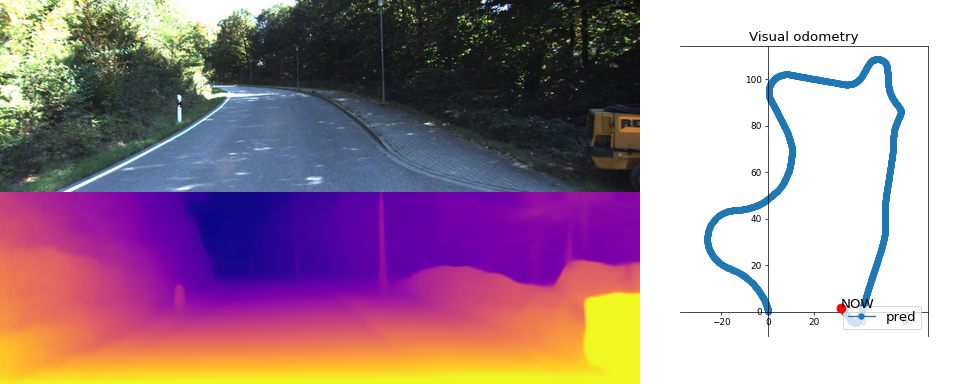

100%|██████████| 1591/1591 [11:05<00:00,  2.39it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
show_and_stream_result_video("assets/kitti_odom_09.mp4", "kitti_odom_09_result.avi")
files.download('kitti_odom_09_result.avi') 

## Cityscapes dataset which the pre-trained model has never seen before
Below the same pre-trained network is applied to the Cityscapes dataset, whose scene is more urban than KITTI's scenes. Based on the result, it can be observed that the networks can produce reasonable predictions, which means the network can generalize to some extend to a new unseen scene. However the performance is not as good as the performance on where it was trained i.e. KITTI. For instance, the objects outlines in depth map are less sharper and the predicted trajectory is curved which should however be straight. To improve the network's generalizability, there have been papers purposing to adapt the network in a self-supervised online fashion such as [7].

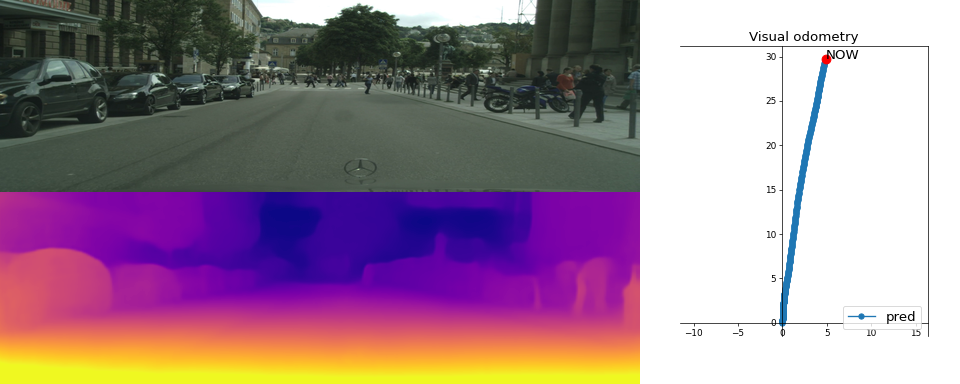

 30%|███       | 345/1150 [03:00<06:57,  1.93it/s]

In [ ]:
def select(seq):
    show_and_stream_result_video("assets/stuttgart_{}.mp4".format(seq), "stuttgart_{}_result.avi".format(seq))
    files.download('stuttgart_{}_result.avi'.format(seq))

## select one of the video clip
# select('00')
# select('01')
select('02')

# Reference

[1] Godard, C., Aodha, O. Mac, Firman, M., & Brostow, G. (2019). Digging into self-supervised monocular depth estimation. Proceedings of the IEEE International Conference on Computer Vision, 2019-Octob(1), 3827–3837. https://doi.org/10.1109/ICCV.2019.00393

[2] kwea123. monodepth2 example. https://gist.github.com/kwea123/3fa35aac268309fc1ccfbe78bb439a28

[3] Tinghui Zhou, Matthew Brown, Noah Snavely, D. L. (2017). Unsupervised learning of depth and ego-motion from video. CVPR, 58–65. https://doi.org/10.1109/AIVR46125.2019.00018

[4] KITTI vision benchmark suite: http://www.cvlibs.net/datasets/kitti/eval_odometry.php

[5] Cityscapes dataset: https://www.cityscapes-dataset.com/

[6] Gordon, A., Li, H., Jonschkowski, R., & Angelova, A. (2019). Depth from videos in the wild: Unsupervised monocular depth learning from unknown cameras. ICCV 2019

[7] Li, S., Wang, X., Cao, Y., Xue, F., Yan, Z., & Zha, H. (2020). Self-Supervised Deep Visual Odometry with Online Adaptation. Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 6338–6347. https://doi.org/10.1109/CVPR42600.2020.00637